In [1]:
!pip install imbalanced-learn pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Optimalisasi Deteksi Dini Patologi Janin Menggunakan KNN dan Random Forest Berbasis SMOTE

## 1. Pendahuluan
Notebook ini bertujuan untuk membangun model Machine Learning untuk mengklasifikasikan kesehatan janin (Normal, Suspect, Pathological). Dataset yang digunakan adalah `fetal_health.csv`.

**Algoritma yang digunakan:**
1. **K-Nearest Neighbor (KNN):** Algoritma berbasis jarak, wajib menggunakan *feature scaling*.
2. **Random Forest:** Algoritma berbasis *ensemble tree*, kuat terhadap data yang tidak seimbang dan tidak memerlukan scaling (namun scaling tetap diterapkan agar seragam).

**Teknik Pra-pemrosesan:**
- Handling Missing Values (jika ada).
- Scaling (StandardScaler).
- Balancing Data (SMOTE) untuk mengatasi ketidakseimbangan kelas pada target `fetal_health`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library Klasifikasi & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Library untuk Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Load Dataset
df = pd.read_csv('fetal_health.csv')

# Cek 5 data teratas
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (2126, 22)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## 2. Exploratory Data Analysis (EDA)
Tahap ini bertujuan untuk memahami karakteristik data.
- **Cek Distribusi Kelas:** Melihat apakah data target seimbang atau tidak.
- **Heatmap Korelasi:** Melihat hubungan antar fitur.
- **Scatter Plot:** Melihat persebaran data pada fitur tertentu.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1484\1851628034.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fetal_health', data=df, palette='viridis')


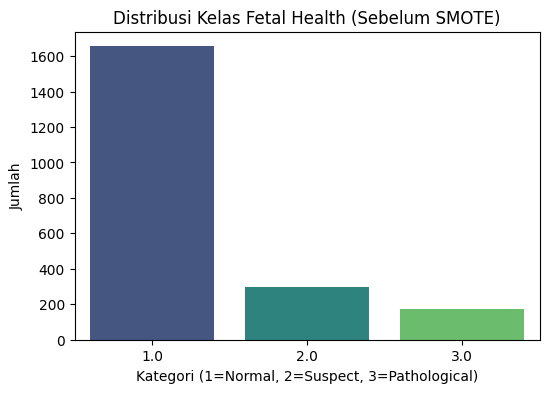

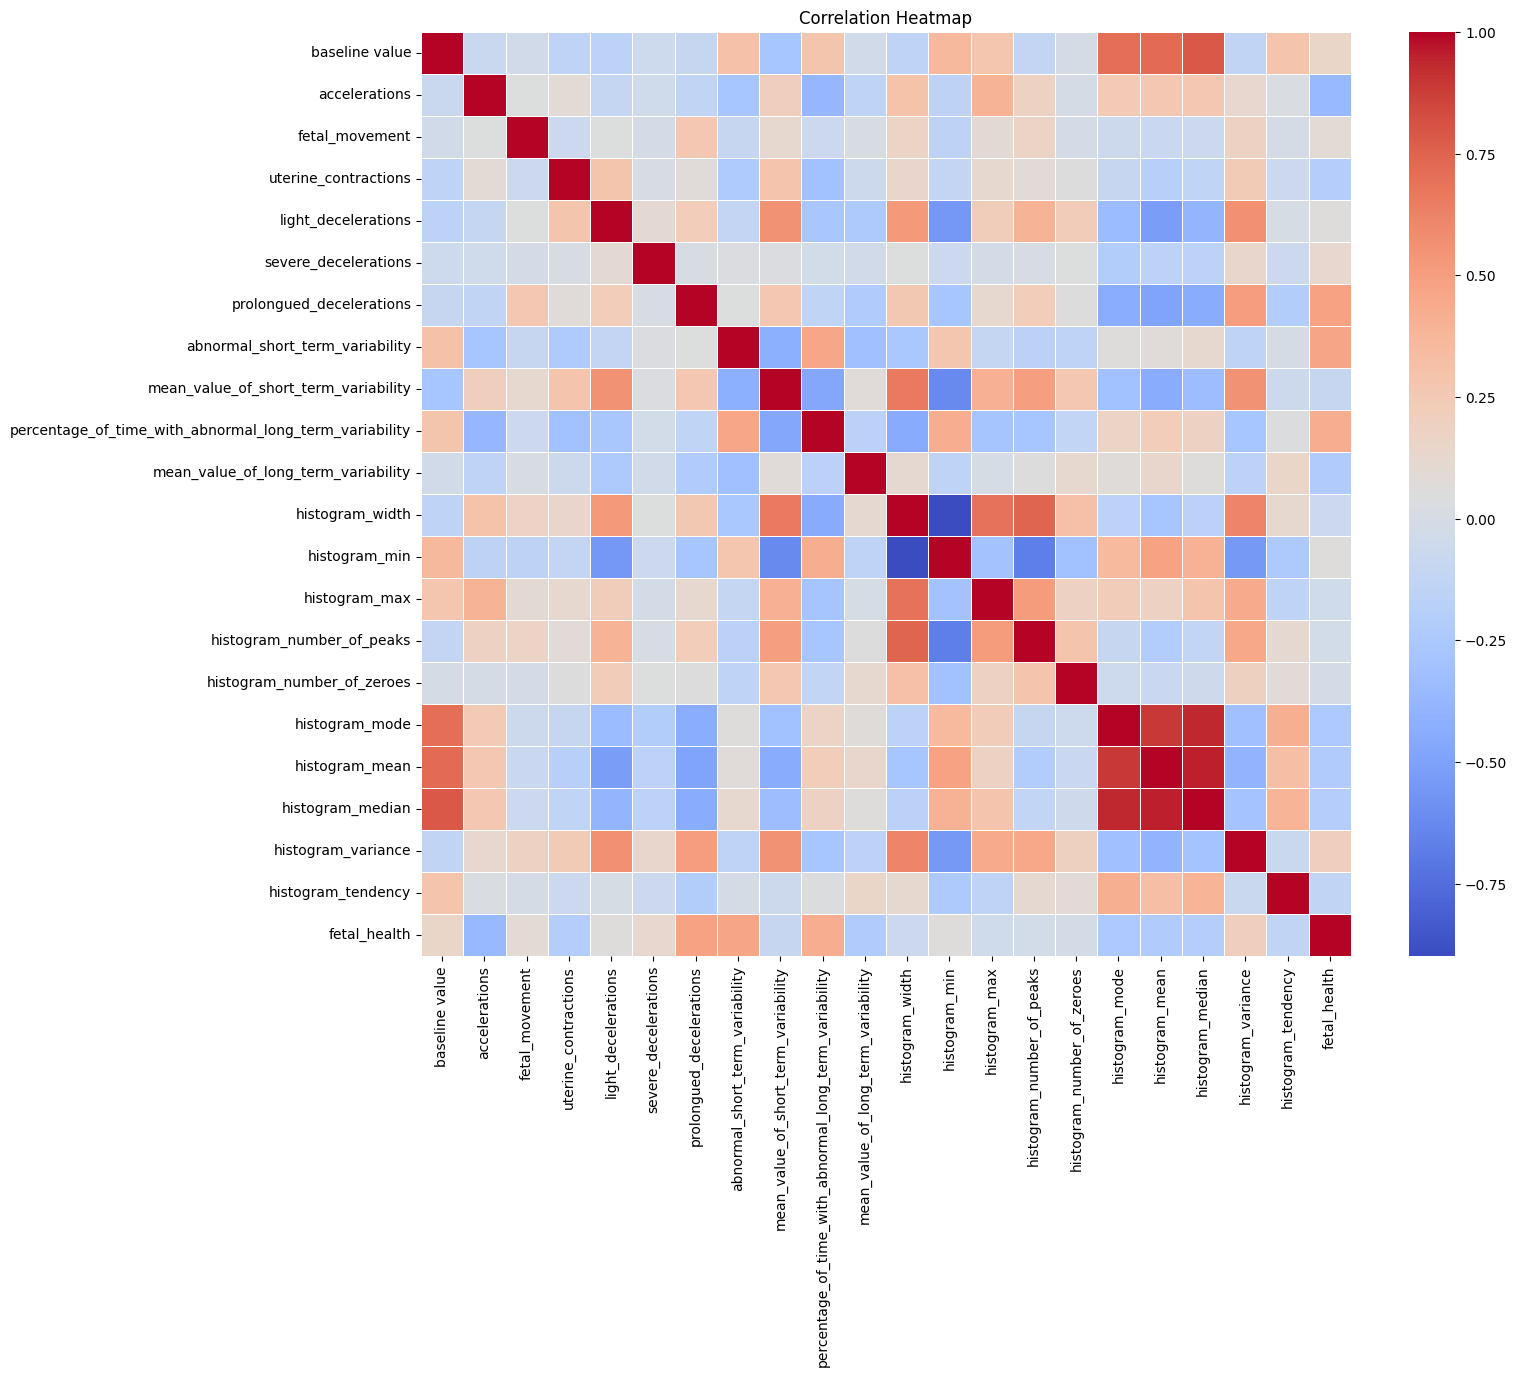

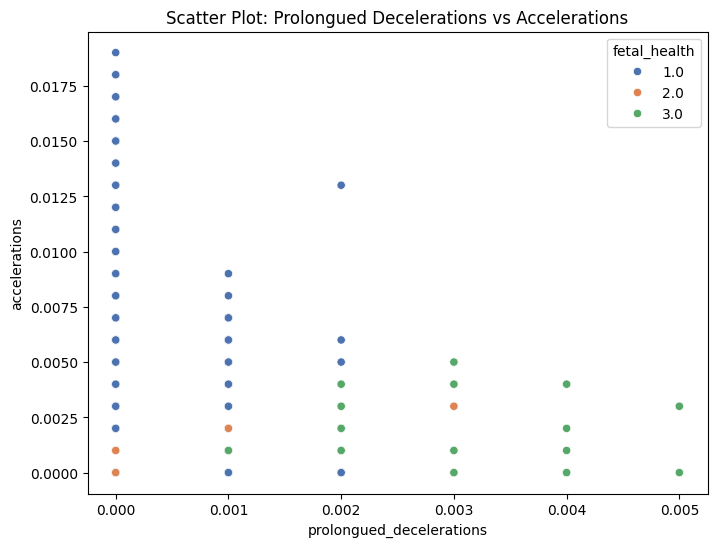

In [3]:
# Cek info dataset (tipe data dan missing value)
df.info()

# 1. Distribusi Kelas Target (fetal_health)
plt.figure(figsize=(6,4))
sns.countplot(x='fetal_health', data=df, palette='viridis')
plt.title('Distribusi Kelas Fetal Health (Sebelum SMOTE)')
plt.xlabel('Kategori (1=Normal, 2=Suspect, 3=Pathological)')
plt.ylabel('Jumlah')
plt.show()

# 2. Heatmap Korelasi
plt.figure(figsize=(15, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 3. Scatter Plot
# Contoh hubungan antara 'prolongued_decelerations' dan 'fetal_movement' terhadap kelas
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='prolongued_decelerations', y='accelerations', hue='fetal_health', palette='deep')
plt.title('Scatter Plot: Prolongued Decelerations vs Accelerations')
plt.show()

## 3. Data Preprocessing
Langkah-langkah yang dilakukan:
1. **Pemisahan Fitur (X) dan Target (y).**
2. **Train-Test Split:** Membagi data menjadi data latih (80%) dan uji (20%).
3. **SMOTE (Synthetic Minority Over-sampling Technique):** Hanya diterapkan pada **Data Latih (X_train)** untuk mencegah *data leakage*.
4. **StandardScaler:** Menyamakan skala data agar KNN bekerja optimal (karena KNN berbasis jarak Euclidean).

In [5]:
# 1. Pisahkan Feature dan Target
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

# 2. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Penerapan SMOTE 
print(f"Jumlah data training sebelum SMOTE: {len(X_train)}")
print(f"Distribusi kelas sebelum SMOTE:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nJumlah data training setelah SMOTE: {len(X_train_resampled)}")
print(f"Distribusi kelas setelah SMOTE:\n{y_train_resampled.value_counts()}")

# 4. Scaling (StandardScaler)
scaler = StandardScaler()

# Fit pada data training yang sudah di-SMOTE, lalu transform ke train dan test
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test) 

Jumlah data training sebelum SMOTE: 1700
Distribusi kelas sebelum SMOTE:
fetal_health
1.0    1323
2.0     236
3.0     141
Name: count, dtype: int64

Jumlah data training setelah SMOTE: 3969
Distribusi kelas setelah SMOTE:
fetal_health
3.0    1323
1.0    1323
2.0    1323
Name: count, dtype: int64


## 4. Modeling: K-Nearest Neighbor (KNN)
KNN bekerja dengan mencari tetangga terdekat. Kita akan menggunakan **Elbow Method** untuk mencari nilai `k` (jumlah tetangga) yang paling optimal dengan melihat tingkat akurasi pada data test.

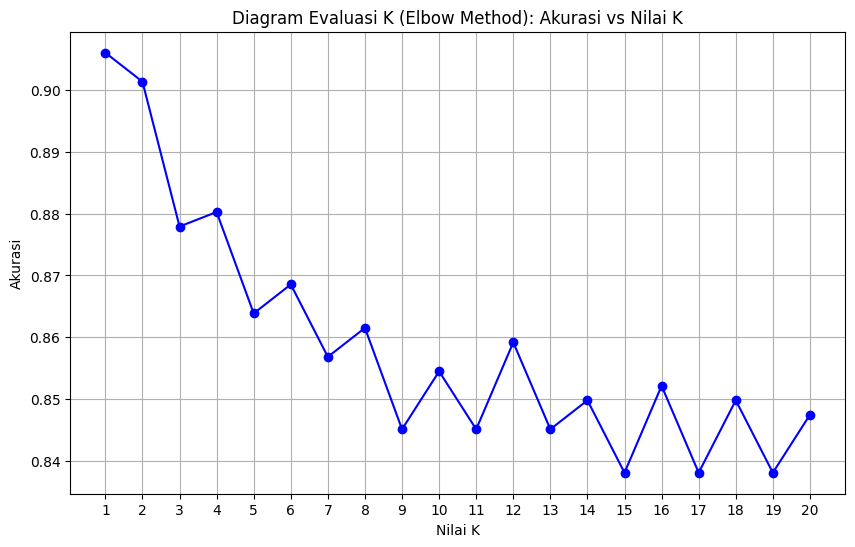

Nilai K terbaik berdasarkan plot adalah: 1


In [6]:
# Diagram Evaluasi K (Elbow Method / Accuracy Plot)
k_range = range(1, 21)
accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_resampled)
    y_pred_k = knn.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred_k))

# Plotting Accuracy vs K Value
plt.figure(figsize=(10,6))
plt.plot(k_range, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Diagram Evaluasi K (Elbow Method): Akurasi vs Nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Memilih K terbaik (misal K=1 atau K yang memiliki akurasi tertinggi stabil)
best_k = k_range[np.argmax(accuracy_scores)]
print(f"Nilai K terbaik berdasarkan plot adalah: {best_k}")

# Training Model KNN dengan Best K
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test_scaled)

## 5. Modeling: Random Forest Classifier
Random Forest adalah algoritma *ensemble* yang terdiri dari banyak Decision Trees. Algoritma ini cenderung memiliki performa tinggi dan stabil. Kita juga akan melihat **Feature Importance** untuk mengetahui fitur apa yang paling mempengaruhi kesehatan janin.

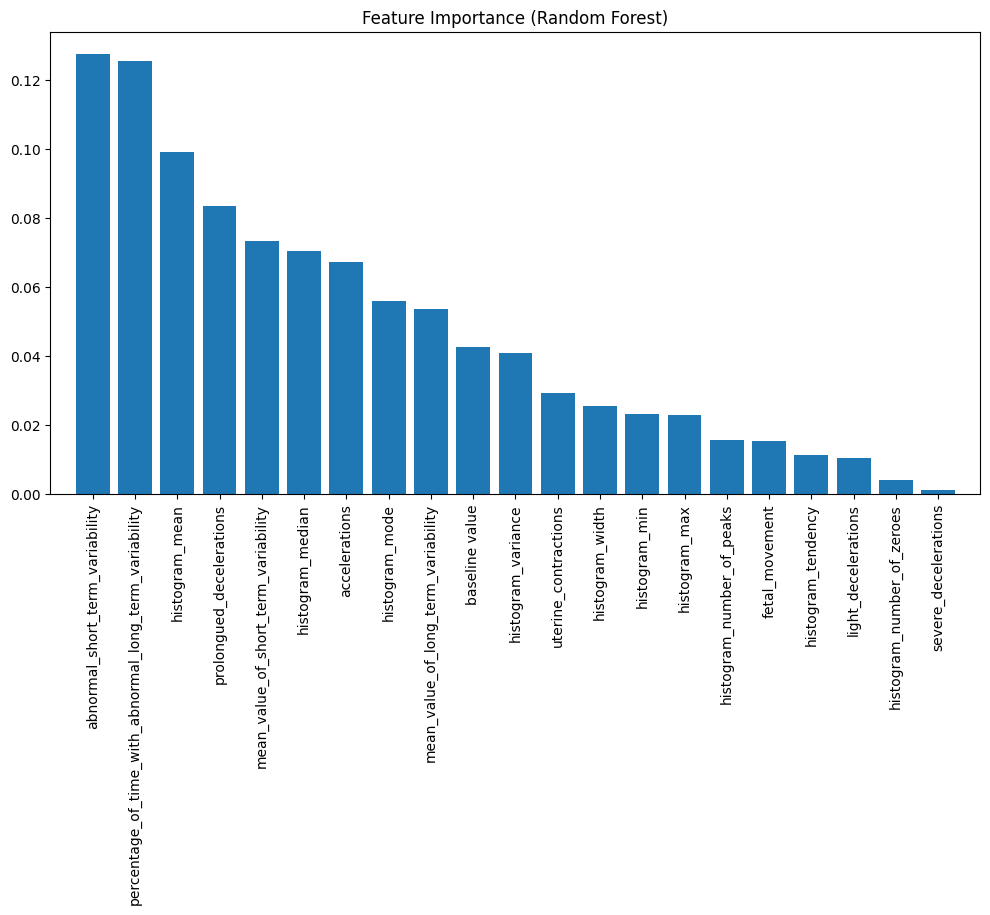

In [7]:
# Training Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)

# Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## 6. Evaluasi Model
Kita akan membandingkan performa KNN dan Random Forest menggunakan metrik:
- **Confusion Matrix:** Melihat detail prediksi benar/salah per kelas.
- **Classification Report:** Melihat Precision, Recall, dan F1-Score.
- **ROC Curve:** Kurva performa untuk klasifikasi multi-kelas.

=== Evaluasi Model K-Nearest Neighbor ===
              precision    recall  f1-score   support

         1.0       0.97      0.94      0.95       332
         2.0       0.67      0.78      0.72        59
         3.0       0.82      0.77      0.79        35

    accuracy                           0.91       426
   macro avg       0.82      0.83      0.82       426
weighted avg       0.91      0.91      0.91       426



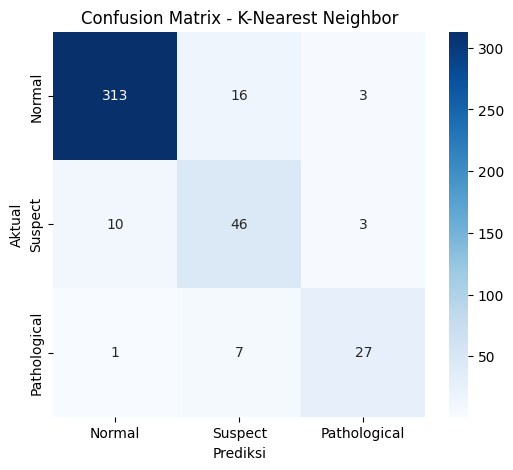

F1 Score (Weighted): 0.9085
--------------------------------------------------
=== Evaluasi Model Random Forest ===
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       332
         2.0       0.76      0.75      0.75        59
         3.0       0.86      0.91      0.89        35

    accuracy                           0.93       426
   macro avg       0.86      0.87      0.87       426
weighted avg       0.93      0.93      0.93       426



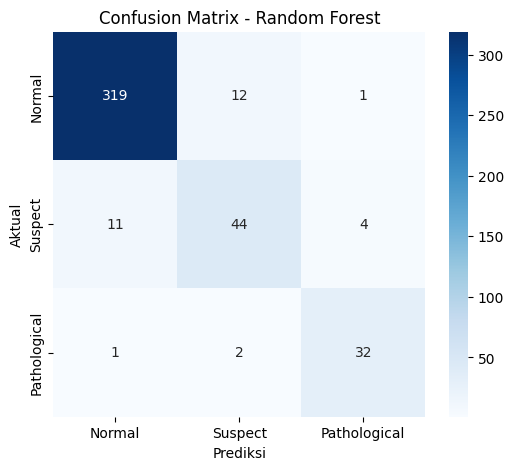

F1 Score (Weighted): 0.9272
--------------------------------------------------


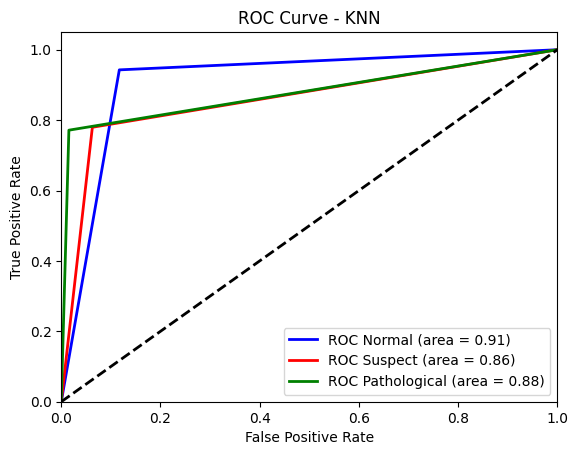

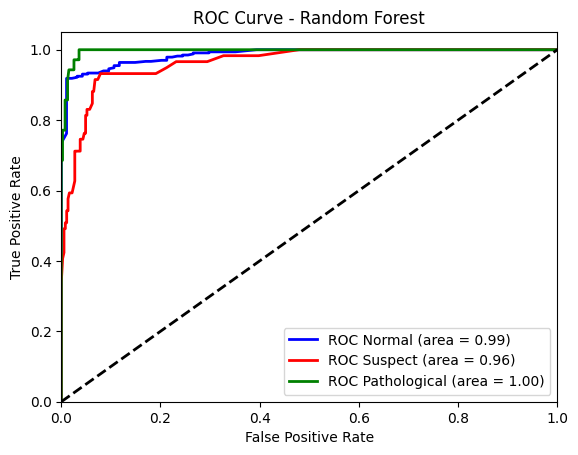

In [8]:
# Fungsi untuk menampilkan evaluasi
def evaluasi_model(y_test, y_pred, model_name):
    print(f"=== Evaluasi Model {model_name} ===")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Suspect', 'Pathological'],
                yticklabels=['Normal', 'Suspect', 'Pathological'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Aktual')
    plt.xlabel('Prediksi')
    plt.show()
    
    print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("-" * 50)

# Evaluasi KNN
evaluasi_model(y_test, y_pred_knn, "K-Nearest Neighbor")

# Evaluasi Random Forest
evaluasi_model(y_test, y_pred_rf, "Random Forest")

# --- ROC Curve Multiclass ---
# Binarize output untuk ROC Multiclass
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

# Prediksi probabilitas
y_score_knn = knn_model.predict_proba(X_test_scaled)
y_score_rf = rf_model.predict_proba(X_test_scaled)

def plot_multiclass_roc(y_test_bin, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green']
    classes_labels = ['Normal', 'Suspect', 'Pathological']
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC {0} (area = {1:0.2f})'.format(classes_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc(y_test_bin, y_score_knn, "KNN")
plot_multiclass_roc(y_test_bin, y_score_rf, "Random Forest")

## 7. Menyimpan Model Terbaik
Berdasarkan evaluasi F1-Score dan Akurasi, biasanya Random Forest memberikan hasil yang lebih baik pada data tabular kompleks. Kita akan menyimpan model Random Forest dan Scaler menggunakan `pickle` agar bisa digunakan di aplikasi **Streamlit**.

In [9]:
import pickle

# Simpan model terbaik (Misal Random Forest)
with open('best_rf_model_fetal_health.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Simpan scaler (PENTING: Streamlit butuh scaler yang sama untuk data input user)
with open('scaler_fetal_health.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model dan Scaler berhasil disimpan!")

Model dan Scaler berhasil disimpan!
